In [11]:
import random
import sys
sys.path.append('src/')
sys.path.append('experiments/')
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc, mean_squared_error
from sklearn.model_selection import train_test_split

from src.clause_generator import ClauseGenerator
from src.ilp_solver import ILPSolver
from src.ilp_problem import ILPProblem
from src.data_utils import DataUtils
from src.visualize import Visualize
from experiments.parameters import get_parameters
from experiments.eval_utils import get_dataset_with_noise, compute_auc, compute_mse, extract

In [12]:
### problem
problem = 'windy_lava'
# problem = 'delete'
#problem = 'plus'
#problem = 'append'
#problem = 'subtree'

### noise_rate
noise_rate = 0

In [13]:
test_size = 0.3
du = DataUtils(problem)
pos, neg, bk, clauses, lang = du.load_data()
pos_train, pos_test = train_test_split(
    pos, test_size=test_size, random_state=7014)
neg_train, neg_test = train_test_split(
    neg, test_size=test_size, random_state=7014)

# N_beam, T_beam, T, m = get_parameters(problem)

### add noise
pos_train_, neg_train_ = get_dataset_with_noise(pos_train, neg_train, noise_rate=noise_rate)
ilp_train = ILPProblem(pos_train_, neg_train_, bk, lang, name=problem)
ilp_train.print()

======= POSITIVE EXAMPLES =======
[diesintwo(tr29,6), diesintwo(tr34,0), diesintwo(tr39,2), diesintwo(tr45,9), diesintwo(tr19,4), diesintwo(tr8,1), diesintwo(tr22,8), diesintwo(tr12,8), diesintwo(tr28,0), diesintwo(tr5,9), diesintwo(tr14,2), diesintwo(tr21,2)]
======= NEGATIVE EXAMPLES =======
[diesintwo(tr12,1), diesintwo(tr38,16), diesintwo(tr39,1), diesintwo(tr5,5), diesintwo(tr44,5), diesintwo(tr39,0), diesintwo(tr22,5), diesintwo(tr12,0), diesintwo(tr23,9), diesintwo(tr23,0), diesintwo(tr29,4), diesintwo(tr29,0), diesintwo(tr23,3), diesintwo(tr38,15), diesintwo(tr12,7), diesintwo(tr44,2), diesintwo(tr5,3), diesintwo(tr12,4), diesintwo(tr38,0), diesintwo(tr23,1), diesintwo(tr12,6), diesintwo(tr5,4), diesintwo(tr9,2), diesintwo(tr38,11), diesintwo(tr5,7), diesintwo(tr19,2), diesintwo(tr22,4), diesintwo(tr44,4), diesintwo(tr19,3), diesintwo(tr45,1), diesintwo(tr8,0), diesintwo(tr29,2), diesintwo(tr45,6), diesintwo(tr21,1), diesintwo(tr45,7), diesintwo(tr38,9), diesintwo(tr45,8), dies

In [14]:
N_beam, T_beam, T, m = (10, 5, 4, 2)

In [15]:
# Causal validation toggle (keeps original behavior when disabled)
causal_enabled = True
causal_weight = 0.5

from src.logic_ops import unify, subs_list

bk_set = set(str(a) for a in bk)

def _body_satisfied(clause, example):
    ok, theta = unify([clause.head, example])
    if not ok:
        return False
    grounded = subs_list(clause, theta)
    return all(str(b) in bk_set for b in grounded.body)

def _init_env():
    import sys
    from pathlib import Path
    sys.path.insert(0, str(Path('../causalgym-main').resolve()))
    for name in list(sys.modules):
        if name == 'causal_gym' or name.startswith('causal_gym.'):
            del sys.modules[name]
    from causal_gym.envs import WindyLavaGridEnv
    env = WindyLavaGridEnv(
        grid_shape=(4, 4),
        start_location=(1, 2),
        target_location=(3, 3),
        lava_cells=[(1, 0), (2, 1)],
        wind_strength=(1.0, 0.0, 0.0, 0.0, 0.0),
        column_wind={},
        cell_wind={(1, 2): (0, -2)},
        terminate_on_lava=True,
    )
    return env

_env_ref = {'env': None}

def _intervention_outcome(clause, example):
    ok, theta = unify([clause.head, example])
    if not ok:
        return None
    grounded = subs_list(clause, theta)
    if not all(str(b) in bk_set for b in grounded.body):
        return None

    agent = None
    wind = None
    for atom in grounded.body:
        if atom.pred.name == 'agentat':
            ax = int(str(atom.terms[2]))
            ay = int(str(atom.terms[3]))
            agent = (ax, ay)
        elif atom.pred.name == 'windat':
            wind = int(str(atom.terms[2]))
    if agent is None:
        return None

    if _env_ref['env'] is None:
        _env_ref['env'] = _init_env()
    env = _env_ref['env']

    env.reset(agent_location=agent)
    if wind is not None:
        env._wind_direction = wind

    terminated = False
    truncated = False
    for _ in range(2):
        action = env.action()
        _, _, terminated, truncated, _ = env.do(action)
        if terminated or truncated:
            break
    return 1.0 if terminated else 0.0

def causal_validator(clause):
    # Intervention-based score using current evaluation set.
    if len(clause.body) == 0:
        return 0.0
    pos_hits = 0.0
    pos_total = 0.0
    neg_hits = 0.0
    neg_total = 0.0
    for e in pos_test:
        outcome = _intervention_outcome(clause, e)
        if outcome is None:
            continue
        pos_hits += outcome
        pos_total += 1.0
    for e in neg_test:
        outcome = _intervention_outcome(clause, e)
        if outcome is None:
            continue
        neg_hits += outcome
        neg_total += 1.0
    if pos_total == 0 or neg_total == 0:
        return 0.0
    score = (pos_hits / pos_total) - (neg_hits / neg_total)
    if score < 0.0:
        score = 0.0
    return score

CG = ClauseGenerator(
    ilp_train,
    infer_step=T,
    max_depth=1,
    max_body_len=5,
    causal_validator=causal_validator if causal_enabled else None,
    causal_weight=causal_weight,
)
solver = ILPSolver(ilp_train, C_0=clauses, CG=CG, m=m, infer_step=T)


In [16]:
N_max = 50 # maximum number of clauses
lr = 1e-2
epoch = 2000

### train weights
clauses, Ws, loss_list = solver.train(
        gen_mode='beam', N_max=N_max, T_beam=T_beam, N_beam=N_beam, epoch=epoch, lr=lr, wd=0.0)

Generating clauses...


======= BEAM SEARCHED CLAUSES ======
diesintwo(0,0):-.
diesintwo(0,0):-terminal(0,0).
diesintwo(0,X):-.
diesintwo(0,X):-diesintwo(X,0),terminal(0,X),terminal(X,0).
diesintwo(0,X):-diesintwo(X,0),terminal(0,X).
diesintwo(0,X):-diesintwo(X,0),terminal(X,0),terminal(0,X).
diesintwo(0,X):-diesintwo(X,0),terminal(X,0).
diesintwo(0,X):-diesintwo(X,0).
diesintwo(0,X):-terminal(0,X),terminal(X,0),diesintwo(X,0).
diesintwo(0,X):-terminal(0,X),terminal(X,0).
diesintwo(0,X):-terminal(0,X).
diesintwo(0,X):-terminal(X,0).
diesintwo(X,0):-.
diesintwo(X,0):-diesintwo(0,X),terminal(0,X),terminal(X,0).
diesintwo(X,0):-diesintwo(0,X),terminal(0,X).
diesintwo(X,0):-diesintwo(0,X),terminal(X,0),terminal(0,X).
diesintwo(X,0):-diesintwo(0,X),terminal(X,0).
diesintwo(X,0):-diesintwo(0,X).
diesintwo(X,0):-terminal(0,X).
diesintwo(X,0):-terminal(X,0),terminal(0,X),diesintwo(0,X).
diesintwo(X,0):-terminal(X,0),terminal(0,X).
diesintwo(X,0):-terminal(X,0).
diesintwo(X,T):-.
diesintwo(X,T):-diesintwo(T,X),termina

100%|██████████| 2000/2000 [00:25<00:00, 79.28it/s, loss=0.68]  

====== LEARNED PROGRAM ======
C_0:  diesintwo(X,T):-. 0.18704336881637573
C_1:  diesintwo(X,0):-diesintwo(0,X),terminal(X,0). 0.05321313440799713


In [ ]:
# diesintwo(traj, t) :- windat(traj, t, W), lavadistance(traj, t, 2), stepadd(t, 2, t2), terminal(traj, t2).

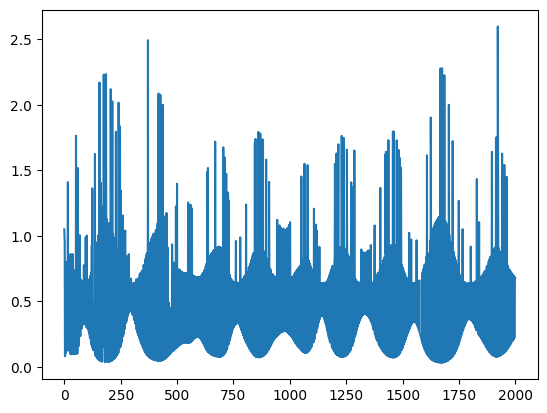

In [17]:
### plot training loss
%matplotlib inline
plt.plot(loss_list)
plt.show()

In [18]:
### evaluate on test data
v_list, facts = solver.predict(pos_test, neg_test, clauses, Ws)
mse = compute_mse(pos_test, neg_test, v_list, facts)
auc = compute_auc(pos_test, neg_test, v_list, facts)

print('====== TEST SCORE =======')
print('Mean-squared test error: ', mse)
print('AUC: ', auc)

Enumerating facts...
Building tensors...
====== TEST SCORE =======
Mean-squared test error:  0.14640575965611885
AUC:  0.6607142857142857


In [19]:
import json
import os
from datetime import datetime

def _fmt(v):
    if isinstance(v, float):
        return str(v).replace('.', 'p')
    return str(v)

results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)
ts = datetime.now().strftime('%Y%m%d_%H%M%S')
gen_mode = locals().get('gen_mode', 'beam')
name_parts = [
    problem,
    f'mode-{gen_mode}',
    f'Nmax-{_fmt(N_max)}',
    f'Tbeam-{_fmt(T_beam)}',
    f'Nbeam-{_fmt(N_beam)}',
    f'epoch-{_fmt(epoch)}',
    f'lr-{_fmt(lr)}',
    f'wd-{_fmt(0.0)}',
    f'm-{_fmt(m)}',
    f'T-{_fmt(T)}',
    ts,
]
out_name = '_'.join(name_parts) + '.json'
out_path = os.path.join(results_dir, out_name)

payload = {
    'problem': problem,
    'mode': gen_mode,
    'hyperparams': {
        'N_max': N_max,
        'T_beam': T_beam,
        'N_beam': N_beam,
        'epoch': epoch,
        'lr': lr,
        'wd': 0.0,
        'm': m,
        'T': T,
    },
    'evaluation': {
        'mse': mse,
    },
    'auc': auc,
    'learned_rules': [str(c) for c in clauses],
}

with open(out_path, 'w') as f:
    json.dump(payload, f, indent=2)

print('Saved results to', out_path)


Saved results to results/windy_lava_mode-beam_Nmax-50_Tbeam-5_Nbeam-10_epoch-2000_lr-0p01_wd-0p0_m-2_T-4_20251224_132503.json


Enumerating facts...
Building tensors...


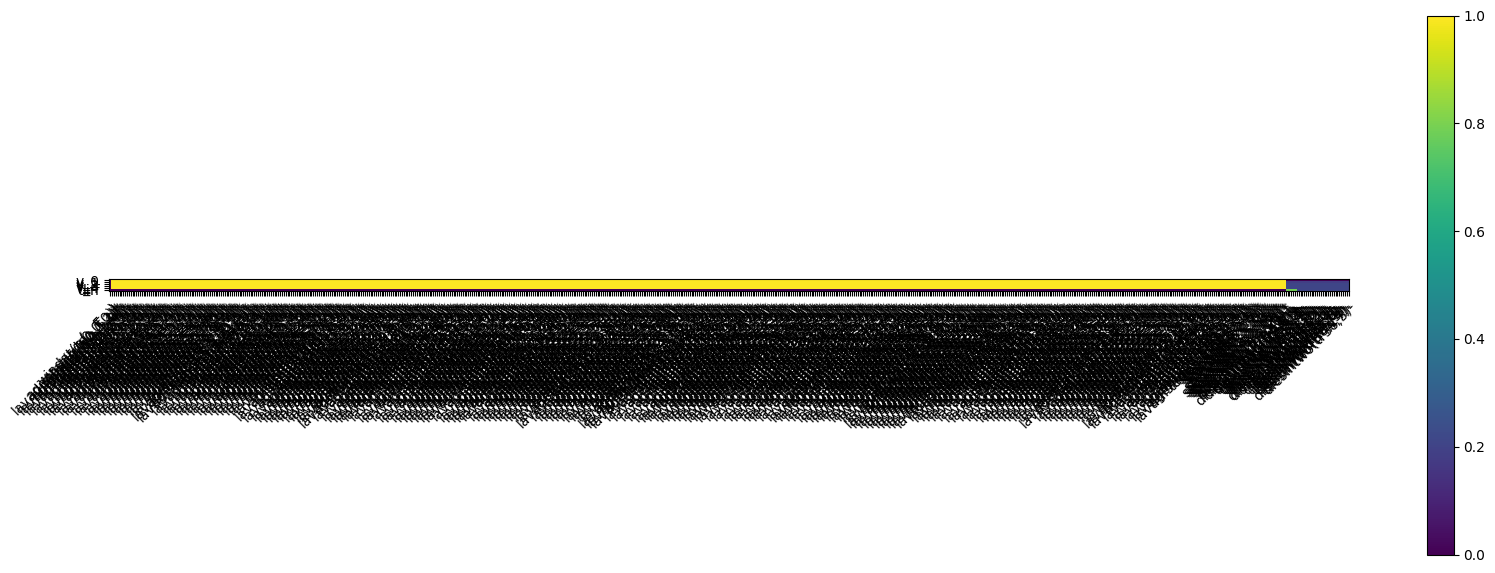

In [20]:
# Visualize v_0, v_1, ..., v_n after learning

v_list, facts = solver.get_valuation_memory(pos_test, neg_test, clauses, Ws)
ilp_test = ILPProblem(pos_test, neg_test, bk, lang, name=problem)
vis = Visualize(ilp_test, name=problem, facts=facts)
vis.plot_valuation_memory(v_list)